# Load Modules

In [33]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')
from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

# Load Data

In [35]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [36]:
feat_to_use = info_col + phot_flux + phot_flux_hilim + phot_flux_lolim + en_flux + en_flux_hilim + en_flux_lolim + powlaw_fit +bb_fit +hard+ intra_obs_var +inter_ob_var 
data_cv = pd.read_csv('filtered_data/cv_old_data.csv' , index_col='obs_id')[feat_to_use]
data_cv.insert(0 , 'class' , ['CV']*len(data_cv))
data_pl  =  pd.read_csv('filtered_data/pl_old_data.csv' , index_col = 'obs_id')[feat_to_use]
data_pl.insert(0 , 'class' , ['PL']*len(data_pl))
data_lx  =  pd.read_csv('filtered_data/lmxb_data.csv' , index_col = 'obs_id')[feat_to_use]
data_lx.insert(0 , 'class' , ['LX']*len(data_lx))

In [37]:
info_col_cl =  info_col+['class']

In [5]:
# sns.histplot(data_cv['num_obs'] , color='black' , alpha = 0.3)
# sns.histplot(data_pl['num_obs'] , color='crimson' ,  alpha = 0.3)
# sns.histplot(data_lx['num_obs'] , color = 'blue' ,  alpha = 0.3)
# plt.show()

In [38]:
data = pd.concat([data_cv , data_pl , data_lx] , axis=0)
data

,class,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,...,var_inter_sigma_h,var_inter_index_m,var_inter_prob_m,var_inter_sigma_m,var_inter_index_s,var_inter_prob_s,var_inter_sigma_s,var_inter_index_u,var_inter_prob_u,var_inter_sigma_u
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_1,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3974.2,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_2,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_3,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CV_0_obs_4,CV,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LX,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_90_obs_0,LX,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LMXB_91_obs_0,LX,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,...,8.934000e-09,5.0,0.8,1.257000e-07,NaN,0.247,5.992000e-09,NaN,NaN,NaN


# Remove sparse columns

In [39]:
sp = [] 
for f in feat_to_use:
    #print(f)
    na = data[feat_to_use][f].isna().value_counts()
    try:
        sp.append(float(1-na[0]/(na[0]+na[1])))
    except:
        sp.append(0)
sp =  np.asarray(sp)
sparsity = pd.DataFrame(
    {
        "feat" : feat_to_use ,
        "sp_val" :sp
    }
).sort_values(by='sp_val' , ascending=False).reset_index(drop=True)
sparsity

,feat,sp_val
0,var_index_u,0.953091
1,var_index_s,0.878587
2,var_index_h,0.876380
3,kp_prob_u,0.871413
4,ks_prob_u,0.870861
...,...,...
101,ra,0.000000
102,num_obs,0.000000
103,name,0.000000
104,src_n,0.000000


In [40]:
sparse_feat = sparsity[sparsity['sp_val']>0.5].sort_values(by='sp_val').reset_index(drop=True)
sparse_feat = sparse_feat['feat'].to_list()
#sparse_feat

In [41]:
dense_feat = sparsity[sparsity['sp_val']<0.5].sort_values(by='sp_val').reset_index(drop=True)
dense_feat = dense_feat['feat'].to_list()
#dense_feat

In [42]:
data_use = data[dense_feat+['class']]
details(data , 'Before removing sparse columns')
details(data_use , 'After removing sparse columns')

Before removing sparse columns
________________________________________________
Sparsity in the data : 0.44
Data shape (1812, 107)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521
After removing sparse columns
________________________________________________
Sparsity in the data : 0.23
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


## Take log

In [43]:
flux_feat = phot_flux + phot_flux_lolim + phot_flux_hilim + en_flux + en_flux_lolim + en_flux_hilim
flux_feat_avail = list(set(flux_feat) & set(dense_feat))
def take_log(data_sent):
    x_train_log = data_sent.copy()
    for f in flux_feat_avail[:]:
        x_train_log.loc[:,f] = -(np.log10(x_train_log.loc[:,f]))
    x_train_log = x_train_log.replace(-np.inf , np.nan)
    x_train_log = x_train_log.replace(np.inf , np.nan)
    return x_train_log


## Take Log of flux columns

In [44]:
df_log = take_log(data_use)
details(df_log)

________________________________________________
Sparsity in the data : 0.23
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


# all-obs imputation

## Impute entire dataset

In [47]:
data_id = df_log[info_col_cl]
data_val = df_log.drop(columns = info_col_cl)
rf_imputer = MissForest(verbose=0 , decreasing=True)
new_data = rf_imputer.fit_transform(data_val)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [48]:
new_imp_data =  pd.DataFrame(new_data , columns = data_val.columns.to_list()  , index=data_val.index.to_list())
new_imp_data.index.name = 'obs_id'

In [49]:
data_imp_v2 = pd.concat([data_id , new_imp_data] , axis=1)
data_imp_v2

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,0.35402,6.237160,5.01,5.10,14.798687,6.139708,15.049084,6.441345,15.263225,4.15
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3974.2,11.31,304.46460,CV,...,0.64499,6.008056,5.60,5.13,14.741296,6.065734,14.867955,6.592282,15.435489,4.29
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.58381,5.808270,5.57,5.10,14.860252,6.155910,14.532244,7.032297,15.762708,4.30
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.58106,6.099438,5.59,5.05,14.841387,6.147389,14.896935,6.630005,15.406790,4.29
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.62028,6.106602,5.58,5.06,14.723615,6.085048,14.911152,6.642394,15.532079,4.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,0.08400,5.338755,5.00,5.02,14.444543,5.786217,14.189364,5.405497,14.260507,4.45
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,0.80700,5.737786,5.00,5.05,15.478078,6.884057,14.499626,5.889410,14.651500,4.48
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.45100,6.466864,3.00,5.00,14.373147,5.747875,15.291664,7.068949,15.893809,3.00


In [50]:
data_imp_v2.to_csv('imputed_data/old-data-all-at-once-imp.csv')

In [51]:
data_imp_v2 = pd.read_csv('imputed_data/old-data-all-at-once-imp.csv' , index_col='obs_id')

In [52]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


In [53]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)

# Combine Obs

In [54]:

df_comb = pd.DataFrame()
for s in data_imp_v2['src_id'].unique()[:]:
    temp = data_imp_v2[data_imp_v2['src_id']==s]
    temp_id =  temp[info_col_cl]
    temp_val = temp.drop(columns=info_col_cl)
    temp_mean = temp_val.mean().to_frame().T
    temp_id_top = temp_id.iloc[0:1].reset_index()
    temp_final = pd.concat([temp_id_top , temp_mean] , axis=1).set_index('obs_id')
    df_comb = df_comb.append(temp_final)
display(df_comb)


,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,0.518803,6.172374,5.311515,5.148182,14.929570,6.258236,14.979935,6.709563,15.466719,4.25
CV_1_obs_0,CV_1,104,[HPH2013]_142__________,2CXO J004242.9+411543,10.67917,41.261980,4035.0,77.08,27912.78000,CV,...,0.212598,4.820913,6.000000,5.000000,13.739299,5.048415,13.652455,5.010605,13.846119,5.00
CV_2_obs_0,CV_2,102,[HPH2013]_169__________,2CXO J004244.3+411607,10.68489,41.268730,4035.0,83.08,37399.46000,CV,...,0.303190,4.855848,8.000000,8.000000,14.147020,5.522478,13.532104,5.086136,13.759112,8.00
CV_3_obs_0,CV_3,102,XMMSL2_J004231.9+411621,2CXO J004231.1+411621,10.62976,41.272670,4913.0,174.76,172643.30000,CV,...,0.096272,4.195978,7.000000,5.000000,12.952036,4.309032,12.978640,4.264402,13.047099,4.00
CV_4_obs_0,CV_4,97,[HPH2013]_205__________,2CXO J004248.7+411624,10.70297,41.273450,4881.4,33.19,3870.74300,CV,...,0.448332,5.486310,6.000000,6.000000,14.691305,6.025054,14.306187,6.036574,14.878180,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,0.084000,5.338755,5.000000,5.020000,14.444543,5.786217,14.189364,5.405497,14.260507,4.45
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,0.807000,5.737786,5.000000,5.050000,15.478078,6.884057,14.499626,5.889410,14.651500,4.48
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.451000,6.466864,3.000000,5.000000,14.373147,5.747875,15.291664,7.068949,15.893809,3.00


# Normalize

In [403]:
#data_imp_norm.to_csv('all_filled_norm.csv')

In [43]:
#data_imp_v2 = pd.read_csv('imputed_data/srcwise-imp_old-data.csv' , index_col = 'obs_id')

In [55]:
data_id = df_comb[info_col]
data_label = df_comb['class']
data_val = df_comb.drop(columns=['class']+info_col)
data_imp_norm = df_comb.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,0.680698,0.729854,-0.266593,-0.208635,0.733687,0.662809,0.812847,1.045836,0.993351,-0.487350
CV_1_obs_0,CV_1,104,[HPH2013]_142__________,2CXO J004242.9+411543,10.67917,41.261980,4035.0,77.08,27912.78000,CV,...,-0.602288,-1.028413,0.145519,-0.299808,-0.987330,-1.081141,-0.940088,-0.930801,-0.849650,-0.053109
CV_2_obs_0,CV_2,102,[HPH2013]_169__________,2CXO J004244.3+411607,10.68489,41.268730,4035.0,83.08,37399.46000,CV,...,-0.222711,-0.982962,1.342676,1.546023,-0.397805,-0.397782,-1.099011,-0.842925,-0.948598,1.683857
CV_3_obs_0,CV_3,102,XMMSL2_J004231.9+411621,2CXO J004231.1+411621,10.62976,41.272670,4913.0,174.76,172643.30000,CV,...,-1.089691,-1.841461,0.744098,-0.299808,-2.125637,-2.146957,-1.829858,-1.798964,-1.758323,-0.632097
CV_4_obs_0,CV_4,97,[HPH2013]_205__________,2CXO J004248.7+411624,10.70297,41.273450,4881.4,33.19,3870.74300,CV,...,0.385427,-0.162724,0.145519,0.315469,0.389179,0.326677,-0.076835,0.262853,0.324044,0.525880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,-1.141109,-0.354694,-0.453059,-0.287503,0.032385,-0.017605,-0.231100,-0.471368,-0.378395,-0.371552
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,1.888233,0.164450,-0.453059,-0.269044,1.526777,1.564925,0.178600,0.091637,0.066257,-0.354183
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.396607,1.112989,-1.650216,-0.299808,-0.070847,-0.072873,1.224485,1.463960,1.479052,-1.211086


In [56]:
details(data_imp_norm)

________________________________________________
Sparsity in the data : 0.00
Data shape (210, 58)
Number of sources : 
CV  	  60 	 60
PL  	  92 	 92
LX  	  58 	 58


In [69]:
verbose = 0
val_acc = []
test_acc = []
for i in tqdm(range(10)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    for cl in class_to_select:
        src = df[df['class']==cl]['src_id'].value_counts().sort_values()
        #display(src)
        src = src.iloc[:int(len(src)*0.3)]
        src_select = src.sample(frac=0.9)
        src_id = src_select.index.to_list()
        src_obs = src_select.to_list()
        temp_src = pd.DataFrame({ 
            'src_id' : src_id , 
            'obs_count' : src_obs
        })
        src_list = src_list.append(temp_src)
    #src_list

    all_src = np.unique(df['src_id'].to_list())
    test_src = src_list['src_id'].to_list()
    train_src= list(set(all_src) - set(src_list['src_id']))
    # if(verbose):
    #     print('Total Number of ssources :' , len(all_src))
    #     print('Training_sources : ' , len(train_src) )
    #     print('Validation sources :' , len(test_src))

    # df = df.replace({
    #     "BH" :2 , 
    #     "NS" : 2 ,
    #     "CV" : 0 , 
    #     "PULSAR" : 1 
    # })


    df= df[df['class'].isin(class_to_select)]
    df 



    df_train  = df[df['src_id'].isin(train_src)]
    df_test = df[df['src_id'].isin(test_src)]

    df_train = df_train[df_train['class'].isin(class_to_select)]
    df_test = df_test[df_test['class'].isin(class_to_select)]

    if(verbose):
        details(df_train)
        details(df_test)

    train_id = df_train[info_col]
    train_label = df_train['class']
    train_value = df_train.drop(columns=['class']+info_col)


    i_val = df_test[info_col]
    y_val = df_test['class']
    x_val = df_test.drop(columns=['class']+info_col)

    clf = RandomForestClassifier(
        n_estimators = 200 , n_jobs=-1
    )
    clf = AdaBoostClassifier(base_estimator=clf ,)
    #clf = xgb.XGBRFClassifier(n_componets=200)
    #clf = xgb.XGBClassifier()
    #x_train , x_test , y_train , y_test = train_test_split(train_value , train_label , test_size=0.1 , stratify=train_label, random_state=9)
    x_train , y_train = train_value , train_label
    clf.fit(x_train , y_train)
    v_sc = clf.score(x_val , y_val)
    test_sc = clf.score(x_train, y_train)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(test_sc , v_sc)

 10%|█         | 1/10 [00:46<06:57, 46.38s/it]

0.9612903225806452 0.7272727272727273


 20%|██        | 2/10 [01:33<06:12, 46.54s/it]

0.9548387096774194 0.7272727272727273


 30%|███       | 3/10 [02:20<05:29, 47.03s/it]

0.9612903225806452 0.7272727272727273


 40%|████      | 4/10 [03:09<04:45, 47.61s/it]

0.9612903225806452 0.7090909090909091


 50%|█████     | 5/10 [03:58<04:00, 48.16s/it]

0.9612903225806452 0.7272727272727273


 60%|██████    | 6/10 [04:43<03:08, 47.20s/it]

0.9612903225806452 0.7090909090909091


 70%|███████   | 7/10 [05:24<02:14, 44.99s/it]

0.9612903225806452 0.7090909090909091


 80%|████████  | 8/10 [06:16<01:34, 47.23s/it]

0.9612903225806452 0.7454545454545455


 90%|█████████ | 9/10 [07:01<00:46, 46.67s/it]

0.9612903225806452 0.7272727272727273


100%|██████████| 10/10 [07:44<00:00, 46.49s/it]

0.9612903225806452 0.7090909090909091


In [71]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,96.064516,72.181818
std,0.204018,1.227179
min,95.483871,70.909091
max,96.129032,74.545455


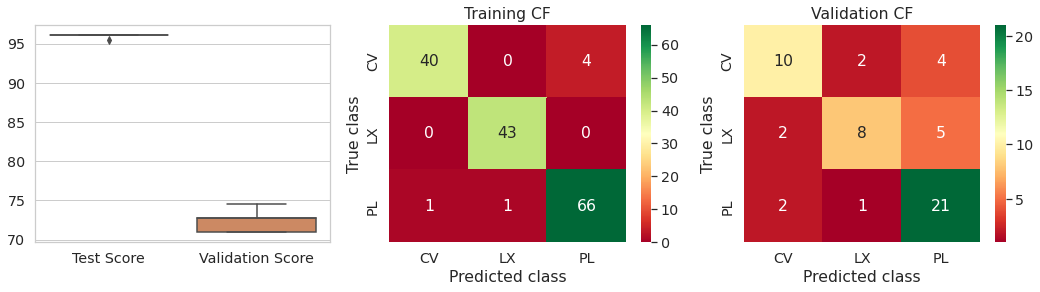

In [72]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_val , clf.predict(x_val) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score

In [79]:
y_true , y_pred = y_val , clf.predict(x_val)


In [80]:
y_pred_prob = clf.predict_proba(x_val)

In [81]:
from sklearn.metrics import precision_score , recall_score , roc_auc_score

,type,CV,LX,PL
0,Precision,0.600000,0.375,0.709677
1,Recall,0.428571,0.400,0.916667


<AxesSubplot:xlabel='variable', ylabel='value'>

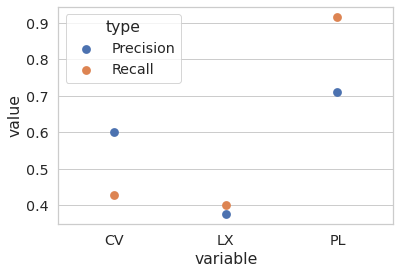

In [114]:

ps = precision_score(y_true , y_pred , average=None)
rc = recall_score(y_true , y_pred , average=None)
#auc = roc_auc_score(y_val_oh , y_pred_prob)
sc = pd.DataFrame(
    np.asarray([ps , rc]) , columns=['CV' , 'LX' , 'PL'] , index=['Precision' , 'Recall']
)
sc.index.name = 'type'
sc =sc.reset_index()
display(sc)
sc = sc.melt(id_vars=['type'] , value_vars = ['CV' , 'LX' , 'PL'])
sns.pointplot(
    data = sc , x = 'variable' , y = 'value' , hue = 'type' , join=False , ax=ax[3]
)

In [391]:
pd.DataFrame({
    'feat' : x_train.columns.to_list() , 
    'val' : clf.feature_importances_
}).sort_values('val' , ascending=False).reset_index(drop=True)

,feat,val
0,photflux_aper_m,0.149696
1,var_inter_prob_m,0.135717
2,flux_aper_m,0.081213
3,var_inter_sigma_h,0.063748
4,var_inter_prob_s,0.054214
5,var_inter_index_h,0.043667
6,var_inter_sigma_m,0.042827
7,var_inter_sigma_b,0.036619
8,var_min_b,0.033070
9,var_inter_prob_b,0.032857
